In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

import warnings
warnings.filterwarnings('ignore')

In [2]:
def best_arm(indices):
    maxi = np.max(indices, axis=1)
    M = indices.shape[0]
    chosen_arms = np.zeros((M,))
    for player in range(M):
        chosen_arms[player] = np.random.choice(np.where(indices[player] == maxi[player])[0])
    return chosen_arms.astype(int)


def klBern(x, y):
    """Kullback-Leibler divergence for Bernoulli distributions."""
    eps = 1e-10
    x = min(max(x, eps), 1-eps)
    y = min(max(y, eps), 1-eps)
    return x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))

def klucb(x, d, div, upperbound, lowerbound=float('-inf'), precision=1e-4, max_iter=50):
    """The generic klUCB index computation.

    Input args.: x, d, div, upperbound, lowerbound=-float('inf'), precision=1e-6,
    where div is the KL divergence to be used.

    finds argmax_{q \in [x,upperbound]} (div(x,q) <= d)

    """
    l = max(x, lowerbound)
    u = upperbound
    count = 0
    while u-l>precision and count <= max_iter:
        count += 1
        m = (l+u)/2
        if div(x, m) > d:
            u = m
        else:
            l = m
    return (l+u)/2

def klucb_ber(x, d):
    ub = 1
    return klucb(x, d, klBern, ub)


In [3]:
class SelfishKLUCB:
    def __init__(self, config, randomized):
        self.klucb = np.vectorize(klucb_ber)
        self.c = 3
        self.randomized = randomized
        self.T = config['horizon']
        self.M = config['M']
        self.mu = config['mu']
        self.mu = np.array(sorted(self.mu, reverse=True))
        self.mu_opt = np.sum(self.mu[:self.M])
        self.K = len(self.mu)
        self.t = 0
        self.regret = np.zeros(self.T)
        self.pulls = np.zeros((self.M, self.K), dtype=np.int32)
        self.successes = np.zeros((self.M, self.K))
        self.mu_hat = np.zeros((self.M, self.K))
        
    def reset(self):
        self.t = 0
        self.regret = np.zeros(self.T)
        self.pulls = np.zeros((self.M, self.K), dtype=np.int32)
        self.successes = np.zeros((self.M, self.K))
        self.mu_hat = np.zeros((self.M, self.K))

    def compute_ucb_idx(self):
        ucb_idx = np.zeros((self.M, self.K))
        
        d = (np.log(self.t) + self.c*np.log(np.log(self.t))) / (self.pulls+1e-7)
        ucb_idx = self.klucb(self.mu_hat, d)
        ucb_idx[self.pulls < 1] = float('+inf')
        return ucb_idx


    def run(self):
        
        self.reset()
        while self.t < self.T:
            
            ucb_idx = self.compute_ucb_idx()

            if self.randomized:
                ucb_idx +=  np.random.normal(0, 1/(self.t+1), size=(self.M, self.K))

            arms_t = best_arm(ucb_idx)

            rewards_t, regret_t, collisions_t = self.draw(arms_t)

            self.update_stats(arms_t=arms_t,
                                rewards=rewards_t,
                                regret_t=regret_t,
                                collisions_t=collisions_t)
            self.t += 1
            
    def draw(self, arms):
        
        counts = collections.Counter(arms)
        rewards = np.zeros((self.M))
        regret_t = self.mu_opt
        collisions_t = np.zeros((self.M, self.K))
        for player in range(self.M):
            if counts[arms[player]] >= 2: # There was collision
                rewards[player] = 0
                collisions_t[player, arms[player]] = 1
            if counts[arms[player]] < 2:
                rewards[player] = np.random.binomial(n=1, p=self.mu[arms[player]])
                regret_t -= self.mu[arms[player]]

        return rewards, regret_t, collisions_t
    
    def compute_mu_hat(self):
        
        mu_hat = np.zeros((self.M, self.K))
        mu_hat = self.successes / (1e-7+self.pulls)
        mu_hat[self.pulls == 0] = 0 # if arm has never been pulled, mu_hat = 0
        return mu_hat
    
    def update_stats(self, arms_t, rewards, regret_t, collisions_t):
        
        if self.t < self.T:
            self.regret[self.t] = regret_t

            self.pulls[np.arange(self.M), arms_t] += 1
            self.successes[np.arange(self.M), arms_t] += rewards
            self.mu_hat = self.compute_mu_hat()
        
    def plot_regret(self):
        cumreg = np.cumsum(self.regret)
        plt.semilogx(cumreg)
        plt.xlabel('t')
        plt.ylabel('Cumulative regret')
        plt.show()

In [4]:
config = {
    'horizon': 10000,
    'M': 2,
    'mu': [0.2, 0.9]
}

In [5]:
selfishKLUCB = SelfishKLUCB(config, randomized = False)

In [6]:
rndSelfishKLUCB = SelfishKLUCB(config, randomized = True)

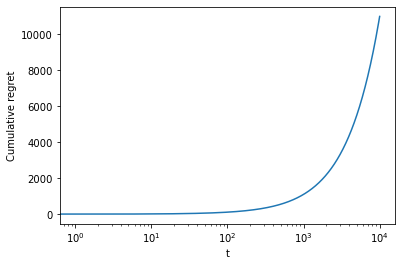

In [7]:
selfishKLUCB.run()
selfishKLUCB.plot_regret()

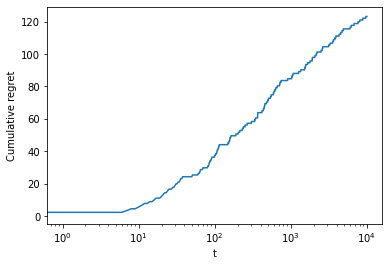

In [8]:
rndSelfishKLUCB.run()
rndSelfishKLUCB.plot_regret()

In [9]:
def compare_regret(selfishKLUCB_cumreg, rndSelfishKLUCB_cumreg):
    plt.loglog(selfishKLUCB_cumreg, label = 'Selfish KLUCB')
    plt.loglog(rndSelfishKLUCB_cumreg, label = 'Randomized Selfish KLUCB')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('Cumulative regret')

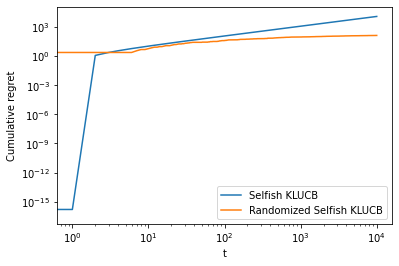

In [10]:
selfishKLUCB_cumreg  = np.cumsum(selfishKLUCB.regret)
rndSelfishKLUCB_cumreg = np.cumsum(rndSelfishKLUCB.regret)

compare_regret(selfishKLUCB_cumreg, rndSelfishKLUCB_cumreg)

In [11]:
exps = [
    {
        'horizon': 10000,
        'M': 2,
        'mu': [[0.1, 0.9],
               [0.01, 0.99],
               [0.9, 0.9],
               [0.1, 0.1]],
        'sucbregret': [],
        'rndsucbregret': []
    },
    {
        'horizon': 10000,
        'M': 3,
        'mu': [[0.2,0.175,0.15,0.125,0.1],
               [0.9,0.875,0.85,0.825,0.8],
               [0.99,0.745,0.5,0.255,0.01]],
        'sucbregret': [],
        'rndsucbregret': []
    },
    {
        'horizon': 10000,
        'M': 5,
        'mu': [[0.2,0.175,0.15,0.125,0.1],
               [0.9,0.875,0.85,0.825,0.8],
               [0.99,0.745,0.5,0.255,0.01],
               [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5],
               [0.509,0.507,0.506,0.505,0.505,0.502,0.5,0.498,0.492,0.492]],
        'sucbregret': [],
        'rndsucbregret': []
    },
]

In [12]:
for exp in exps:
    config = {}
    config['horizon'] = exp['horizon']
    config['M'] = exp['M']
    
    for mu in exp['mu']:
        config['mu'] = mu
        
        sucb = SelfishKLUCB(config, False)
        sucb.run()
        exp['sucbregret'].append(sucb.regret)
        
        rndsucb = SelfishKLUCB(config, True)
        rndsucb.run()
        exp['rndsucbregret'].append(rndsucb.regret)

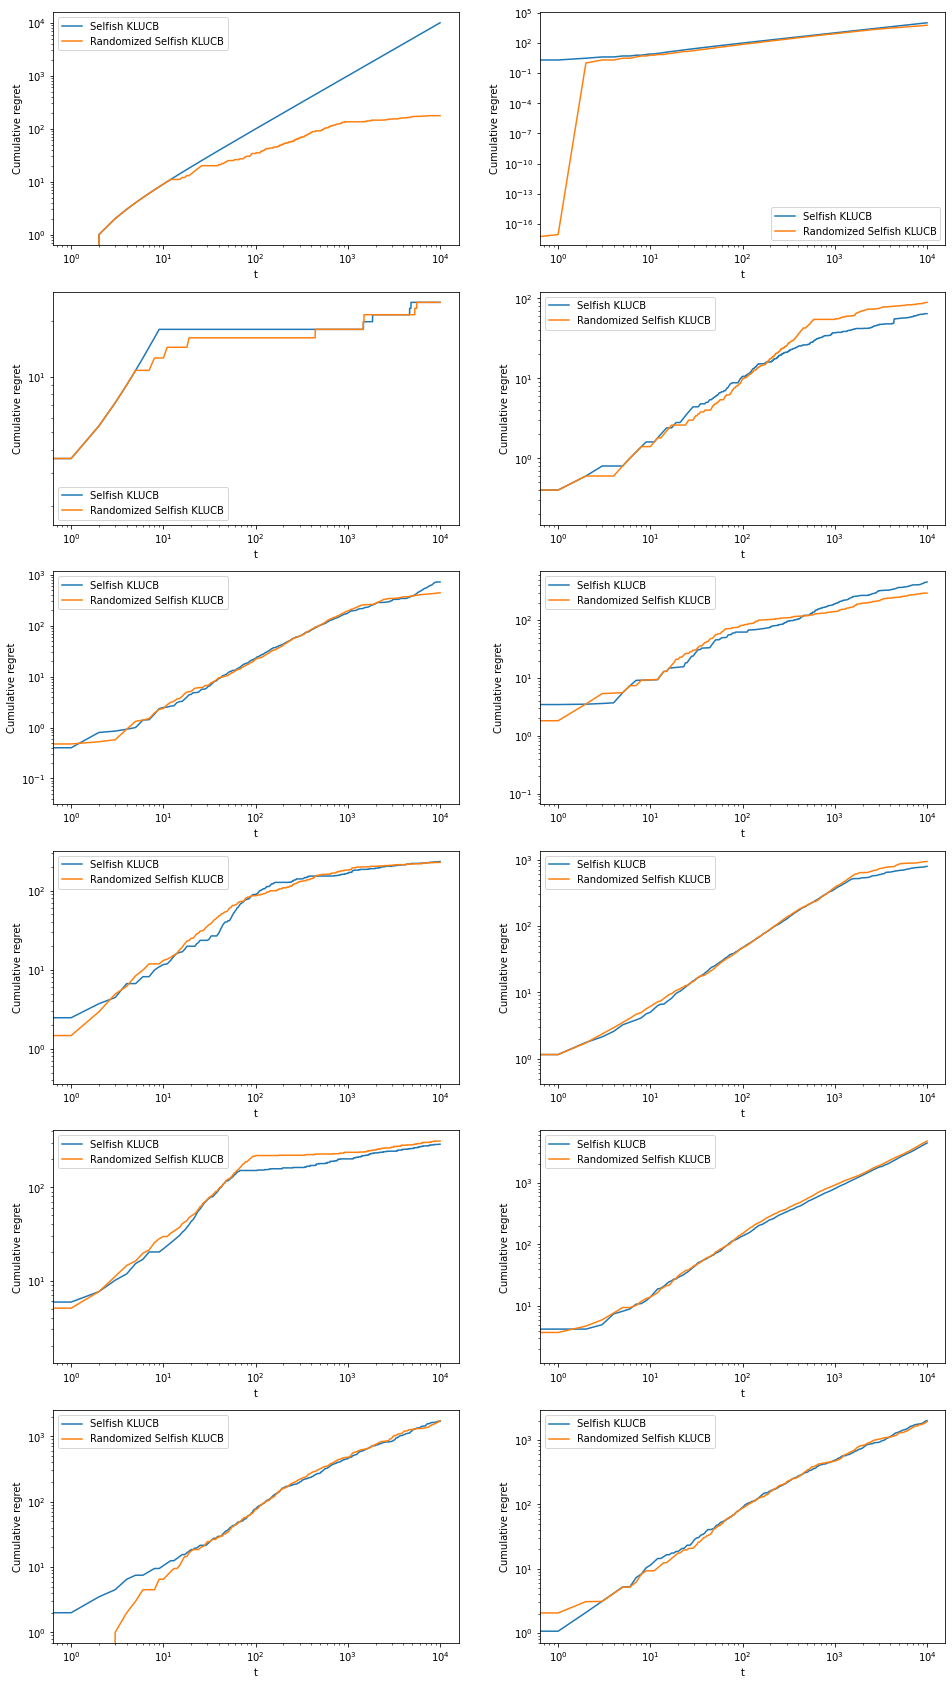

In [13]:
plt.figure(figsize = (16,30))
idx = 1
for exp in exps:
    for i, mu in enumerate(exp['mu']):
        plt.subplot(6, 2, idx)
        compare_regret(np.cumsum(exp['sucbregret'][i]), np.cumsum(exp['rndsucbregret'][i]))
        idx+=1
plt.show()